In [1]:
from __future__ import print_function, division, absolute_import
import os
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import numpy as np
import itertools
from math import pi
import time
import matplotlib.pyplot as plt
import h5py

# Shadowing

Before we can talk about the statistics and proportion of space-time that each orbit family covers,
we must first determine the baselines/threshold values for the shadowing metric. The most important
reason is simply to get a threshold value which is non-arbitary, based upon the distribution of this metric when
ranging over families, group orbits, and arbitrary trajectory segments in space-time. The second reason is to
delve into the details of the families themselves. As we shall see, not every orbit reached by numerical continuation is necessarily in the same continuous family. If accidentally mixed, then the thresholds as determined by the
distributions of the shadowing metric likely do not make sense. Persistent homology is used towards this end. It provides a guide for how to determine both the sampling and bounds of the members of each family to be used
as our covering set.

## Defect family investigation

Before jumping into the full problem, i.e. before using multiple continuous families, let us first investigate
a single family. To do so, we can import the previously derived family (produced via continuation).

In [8]:
covering = read_h5('../../notebooks/covering_old.h5')
defect_family = covering[0]
family_size = [len(x) for x in covering]
defect_family = [x.resize(32, 32).transform(to='field') for x in defect_family]

In [9]:
covering = [[x.resize(32,32).transform(to='field')for x in fam] for fam in covering]

In [10]:
defect_family = sorted(defect_family, key=lambda x : x.x)

First, a quick glimpse through example orbits reached by continuation. 

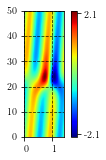

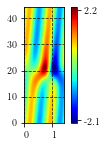

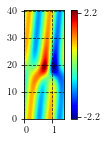

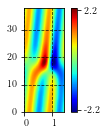

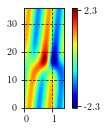

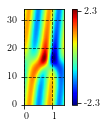

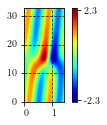

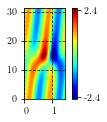

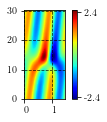

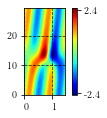

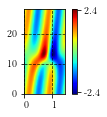

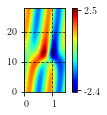

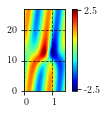

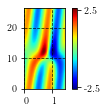

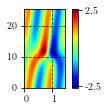

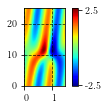

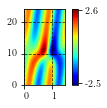

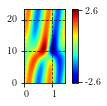

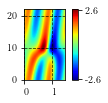

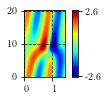

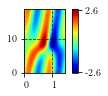

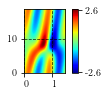

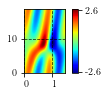

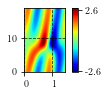

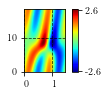

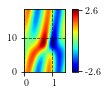

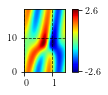

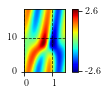

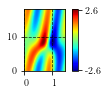

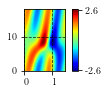

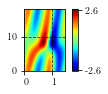

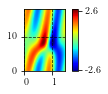

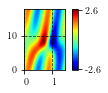

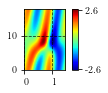

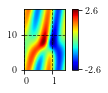

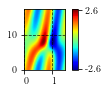

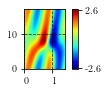

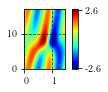

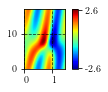

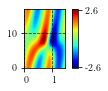

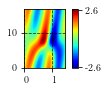

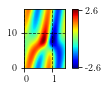

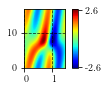

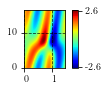

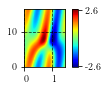

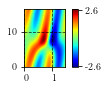

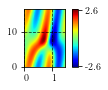

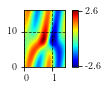

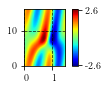

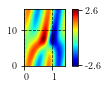

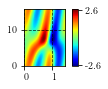

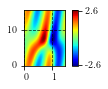

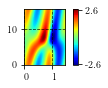

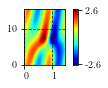

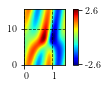

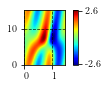

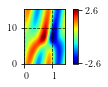

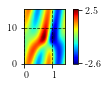

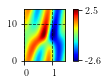

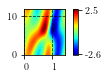

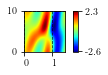

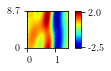

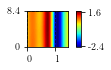

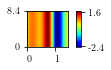

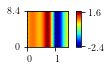

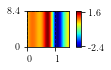

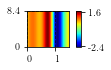

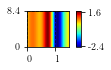

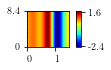

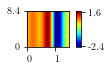

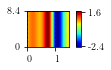

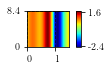

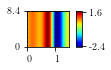

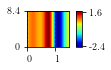

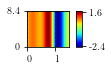

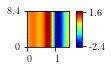

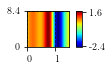

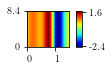

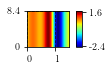

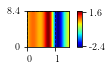

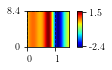

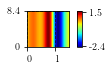

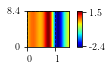

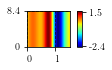

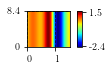

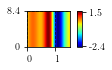

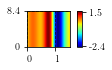

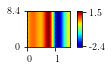

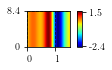

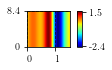

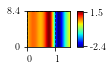

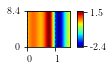

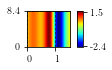

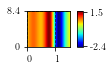

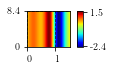

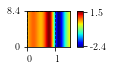

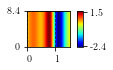

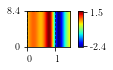

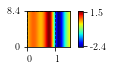

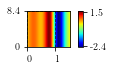

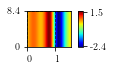

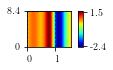

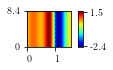

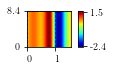

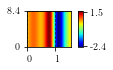

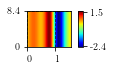

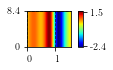

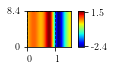

In [11]:
for x in defect_family:
    x.plot()

### Methodology

To collect our distribution of the amplitude difference metric, there are three choices to be made.

    1. The base orbits to scan over
    2. How often to sample them (i.e. how many window positions to compute the amplitude difference).
    3. How many group orbit members to use for each window orbit.
    
For the preliminary investigations, thirty different trajectory segments produced by integration are used, each of which has large spatiotemporal area. To reduce their relations to one another, the trajectory segments are part of a very long trajectory which has been chopped into pieces. Every other piece is collected to be used as a base orbit. Clearly if regions of space-time can be strongly correlated when separated by 500 dimensionless time units, this breaks down.

Instead of exhaustively computing the statistic; for every position for each group orbit member in each family, the
sampling is done by taking a subset of the group orbit members and a subset of the positions; for each member of the
continuous family defined in ```defect_family```
    
Additionally, the windows are rediscretized to abide by the same grid spacing as the base orbit as clearly
shadowings are assumed to be the same size as the orbits they shadow. 

In [12]:
base_orbits_30 = read_h5('../../notebooks/large_trajectories.h5', tuple(['/'+str(i) for i in range(30)]))

To compute the amplitude differences, iterate over the windows (family members), each window's group orbit (taken to be discrete subgroup for this run, and the 30 base orbits (trajectories). 

In [80]:
# 114 members in family, originally, 30720 is the number of replicates * number of group orbit members for each member. 
defect_family_scores = np.zeros([len(defect_family), 1920])
for j, window in enumerate(defect_family):
    member_defect_family_scores = []
    for base in base_orbits_30:
        for gwindow in window.group_orbit(discrete=True):
            member_defect_family_scores.extend(scan(base, gwindow, strides=(128, 128))[0])
    defect_family_scores[j,:] = np.array(member_defect_family_scores).ravel()

Visualize the distribution of all values. 

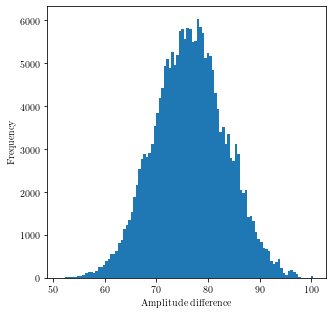

In [82]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
ax1.hist(defect_family_scores.ravel(), bins=100)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Amplitude difference')
plt.show()

The distribution for each family member (all group orbit members included) can be overlaid on top of one another to approximate whether the variables can be treated as IID or not. 



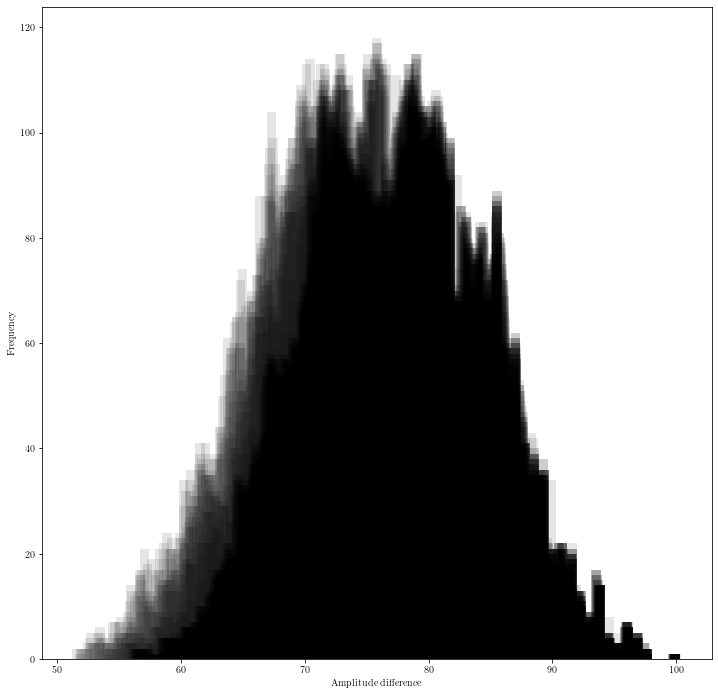

In [83]:
plt.figure(figsize=(12,12))
for g in defect_family_scores:
    plt.hist(g.ravel(), alpha=0.1, color='black', bins=50)
plt.ylabel('Frequency')
plt.xlabel('Amplitude difference')
plt.show()

Because we want thresholds for each family, it does not make sense to me to use a single threshold value if each
member has a different distribution. To determine the bounds of each family, I appeal to persistent homology;
specifically, the "bottleneck distance" between the family members. This is made accessible through the ```gudhi``` package, which I have built in some wrappers for.

In [84]:
import orbithunter.persistent_homology as ohgudhi

Take the pairwise bottleneck distance between each family member and plot as as a symmetric matrix

In [22]:
homology_scores = []
for families in covering:
    family_scores = []
    for orbit1, orbit2 in itertools.product(families, families):
        family_scores.append(ohgudhi.gudhi_distance(orbit1, orbit2, metric='bottleneck'))
    homology_scores.append(family_scores)

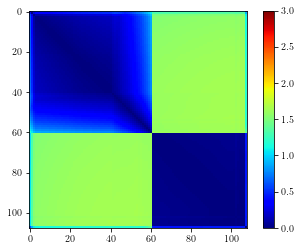

In [88]:
defect_homology_scores = homology_scores[0]
defect_family = covering[0]
plt.imshow(np.array(defect_homology_scores).reshape(len(defect_family), len(defect_family)), cmap='jet', vmin=0, vmax=3)
plt.colorbar()
plt.show()

The structure of this matrix is quasi-block diagonal. Within each block the family members are similar; therefore, we find good the partitions into blocks (by thresholding) then we can recompute the distribution using only that subset of family members. Take the defect family for example. Its distance matrix and the corresponding thresholding procedure developed in the figures below.

Thresholding by an arbitrary value yields approximately three blocks. The first of which is chosen to find our distribution.

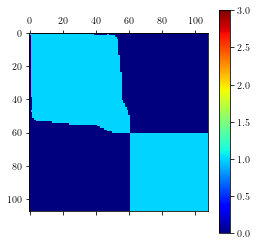

In [92]:
defect_homology_scores_mask = (np.array(defect_homology_scores).reshape(len(defect_family), len(defect_family))<0.5).astype(float)
plt.matshow(defect_homology_scores_mask, cmap='jet', vmin=0, vmax=3)
plt.colorbar()
plt.show()

Take all values in following block, as an approximation.

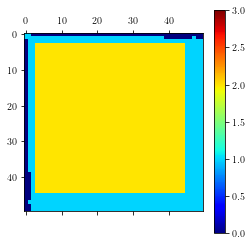

In [93]:
truth_values = (np.array(defect_homology_scores).reshape(len(defect_family), len(defect_family))<0.5)[:50,:50].astype(float)
truth_values[3:45, 3:45] = 2
plt.matshow(truth_values, cmap='jet', vmin=0, vmax=3)
plt.colorbar()
plt.show()

The block compares the entire bottleneck distance matrix in the following manner

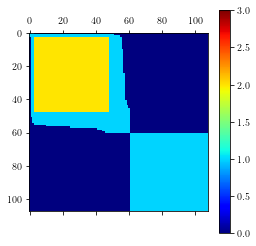

In [30]:
homology_scores_blocked = defect_homology_scores_mask.copy()
homology_scores_blocked[3:48, 3:48] = 2
plt.matshow(homology_scores_blocked, cmap='jet', vmin=0, vmax=3)
plt.colorbar()
plt.show()

If we plot it as a single distribution and compare before and after, we get the following

In [71]:
i = 0
for j, window in enumerate(defect_family):
    member_scores = []
    for base in base_orbits_30:
        for gwindow in window.group_orbit(discrete=True):
#             member_scores.extend(scan(base, gwindow, strides=(128, 128))[0])
            i += 1

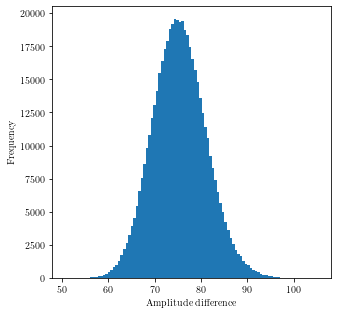

In [75]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
ax1.hist(np.concatenate(small_cover_scores[0]), bins=100)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Amplitude difference')
plt.show()

In [76]:
# fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,6))
# ax1.hist(small_cover_scores[0].ravel(), bins=100)
# ax2.hist(scores[3:48].ravel(), bins=100)
# ax1.set_ylabel('Frequency')
# ax1.set_xlabel('Amplitude difference')
# ax2.set_ylabel('')
# ax2.set_xlabel('Amplitude difference')
# ax1.set_ylim([0,20000])
# ax2.set_ylim([0,20000])
# plt.show()

In [94]:
from scipy.stats import skew, kurtosis

Compare skew, kurtosis before and after blocking

In [96]:
print('Before blocking, skew={} and kurtosis={}'.format(skew(defect_family_scores.ravel()),
                                                        kurtosis(defect_family_scores.ravel())))

Before blocking, skew=0.02070297271030696 and kurtosis=-0.11304153925276772


In [79]:
print('After blocking, skew={} and kurtosis={}'.format(skew(scores[3:48].ravel()), kurtosis(scores[3:48].ravel())))

AttributeError: 'list' object has no attribute 'ravel'

And the overlapping distributions, which look closer to a single distribution than before.

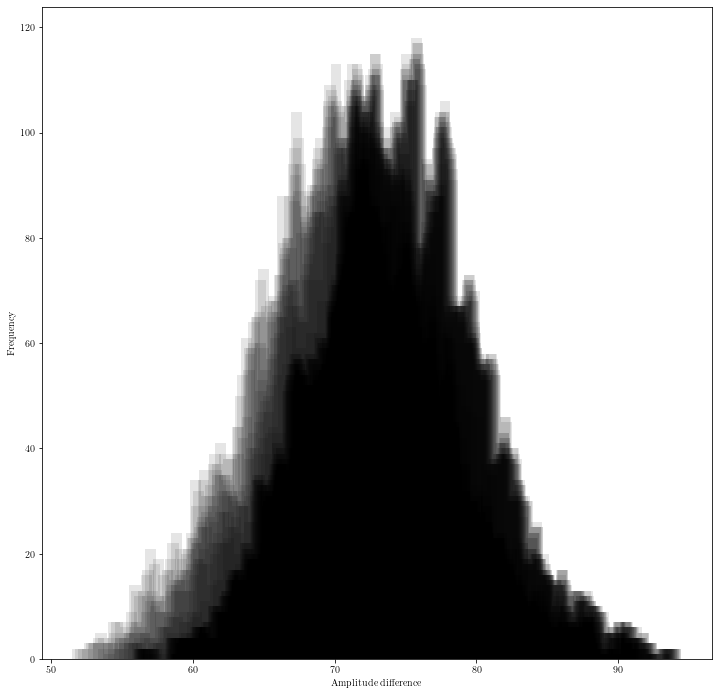

In [35]:
plt.figure(figsize=(12,12))
for g in scores[3:48, :]:
    plt.hist(g.ravel(), alpha=0.1, color='black', bins=50)
plt.ylabel('Frequency')
plt.xlabel('Amplitude difference')
plt.show()

Let's see how the orbits inside and outside this block compare.

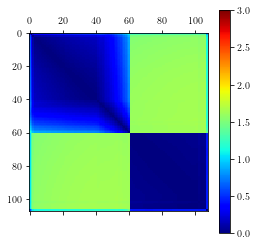

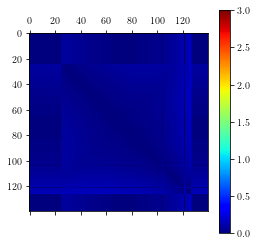

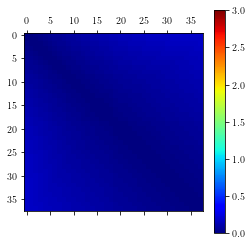

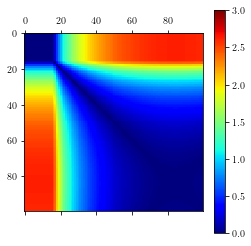

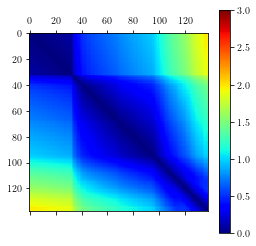

In [36]:
for family_len, family_scores in zip(family_size, homology_scores):
    bottleneck_dist_mat = np.array(family_scores).reshape(family_len, family_len)
    plt.matshow(bottleneck_dist_mat, cmap='jet', vmin=0, vmax=3)
    plt.colorbar()
    plt.show()

In [37]:
# for slicing purposes
covering = [np.array(x) for x in covering]
small_covering = np.concatenate([np.array(covering[0])[[5, 45]], np.array(covering[1])[[10, 130]],
                         np.array(covering[2])[[5, 35]], np.array(covering[3])[[60, 90]],
                         np.array(covering[4])[[40, 100]]])

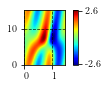

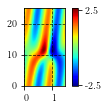

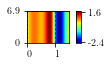

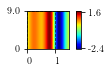

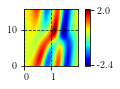

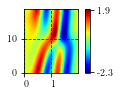

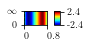

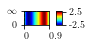

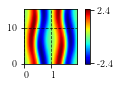

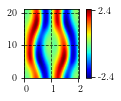

In [38]:
for x in small_covering:
    x.plot()

Because we have reduced the number of family members by an order of a hundred, we need to increase the sampling rate
to get more accurate statistics. Fundamental domains yes or no?

In [42]:
# Two members of each family, sparse sample from 1000 base orbits instead of dense sample of 30. 
small_cover_scores = []
for j, window in enumerate(small_covering):
    window = window.transform(to='field')
    member_scores = []
    for base_num in range(1000):
        base = read_h5('../../notebooks/large_trajectories.h5', '/'+str(base_num))
        for gwindow in window.group_orbit(rolls=(8, 8)):
            member_scores.extend(scan(base, gwindow, strides=(128, 128))[0])
    print(j, end=' ')
    small_cover_scores.append(member_scores)

# Two members of each family, sparse sample from 1000 base orbits instead of dense sample of 30. 
small_cover_scores_fundamental_domain = []
for j, window in enumerate(small_covering):
    window = window.transform(to='field')
    member_scores_fundamental_domain = []
    for base_num in range(1000):
        base = read_h5('../../notebooks/large_trajectories.h5', '/'+str(base_num))
        for gwindow in window.group_orbit(rolls=(8, 8), fundamental_domain=True):
            member_scores_fundamental_domain.extend(scan(base, gwindow, strides=(128, 128))[0])
    print(j, end=' ')
    small_cover_scores_fundamental_domain.append(member_scores_fundamental_domain)

0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 

In [46]:
def critical_values(scores):
    cval = [0.0001, 0.001, 0.01, 0.05]
    return [np.quantile(scores, q) for q in cval]

In [47]:
strict_cvals = []
cvals = []
strict_fd_cvals = [] 
fd_cvals = []
for x in small_cover_cvals:
    strict_cvals.append(critical_values(np.array(x).ravel())[0])
    cvals.append(critical_values(np.array(x).ravel())[1])
    
for x in small_cover_cvals_fundamental_domain:
    strict_fd_cvals.append(critical_values(np.array(x).ravel())[0])
    fd_cvals.append(critical_values(np.array(x).ravel())[1])
    
for x, scrs, scrs_fd in zip(small_covering, small_cover_cvals, small_cover_cvals_fundamental_domain):
    setattr(x, 'critical_values', critical_values(scrs))
    setattr(x, 'fundamental_domain_critical_values', critical_values(scrs_fd))

For thresholds, compute the critical values associated with the 0.01%, 0.1%, 1%, 5% percent thresholds.

Assign these values as attributes of the Orbit instances, so that they automatically get saved as attributes
within the .h5 file.

In [58]:
for x in small_covering:
    x.to_h5('small_cover.h5', verbose=True)

Writing dataset "/0" to file small_cover32.h5
Writing dataset "/1" to file small_cover32.h5
Writing dataset "/2" to file small_cover32.h5
Writing dataset "/3" to file small_cover32.h5
Writing dataset "/4" to file small_cover32.h5
Writing dataset "/5" to file small_cover32.h5
Writing dataset "/6" to file small_cover32.h5
Writing dataset "/7" to file small_cover32.h5
Writing dataset "/8" to file small_cover32.h5
Writing dataset "/9" to file small_cover32.h5


In [45]:
from orbithunter.persistent_homology import gudhi_distance_from_persistence, orbit_persistence
score_type='persistence'
scoring_function = gudhi_distance_from_persistence
persistence_function = orbit_persistence

In [59]:
# Two members of each family, sparse sample from 1000 base orbits instead of dense sample of 30. 
small_cover_persistence_scores = []
for j, window in enumerate(small_covering):
    window = window.transform(to='field')
    member_persistence_scores = []
    for base_num in range(2):
        base = read_h5('../../notebooks/large_trajectories.h5', '/'+str(base_num))
        for gwindow in window.group_orbit(rolls=(8, 8)):
            member_persistence_scores.extend(scan(base, gwindow, strides=(128, 128),
                                                  score_type='persistence',
                                                  scoring_function=gudhi_distance_from_persistence,
                                                  persistence_function=orbit_persistence)[0])
    print(j, end=' ')
    small_cover_persistence_scores.append(member_persistence_scores)

# Two members of each family, sparse sample from 1000 base orbits instead of dense sample of 30. 
small_cover_persistence_scores_fundamental_domain = []
for j, window in enumerate(small_covering):
    window = window.transform(to='field')
    member_persistence_scores_fundamental_domain = []
    for base_num in range(2):
        base = read_h5('../../notebooks/large_trajectories.h5', '/'+str(base_num))
        for gwindow in window.group_orbit(rolls=(8, 8), fundamental_domain=True):
            member_persistence_scores_fundamental_domain.extend(scan(base, gwindow, strides=(128, 128),
                                                  score_type='persistence',
                                                  scoring_function=gudhi_distance_from_persistence,
                                                  persistence_function=orbit_persistence)[0])
    print(j, end=' ')
    small_cover_persistence_scores_fundamental_domain.append(member_persistence_scores_fundamental_domain)

0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 

In [62]:
for x, scrs, scrs_fd in zip(small_covering, small_cover_persistence_scores,
                            small_cover_persistence_scores_fundamental_domain):
    setattr(x, 'critical_persistence_values', critical_values(scrs))
    setattr(x, 'fundamental_domain_critical_persistence_values', critical_values(scrs_fd))

In [61]:
for x in small_covering:
    x.to_h5('small_cover.h5', verbose=True)

Writing dataset "/0" to file small_cover.h5
Writing dataset "/1" to file small_cover.h5
Writing dataset "/2" to file small_cover.h5
Writing dataset "/3" to file small_cover.h5
Writing dataset "/4" to file small_cover.h5
Writing dataset "/5" to file small_cover.h5
Writing dataset "/6" to file small_cover.h5
Writing dataset "/7" to file small_cover.h5
Writing dataset "/8" to file small_cover.h5
Writing dataset "/9" to file small_cover.h5


In [39]:
# medium_covering = np.concatenate([covering[0][[5, 15, 25, 35, 45]], covering[1][[10, 40, 70, 100, 130]],
#                          covering[2][[5, 15, 25, 35]], covering[3][[50, 75, 99]],
#                          covering[4][[20, 40, 60, 80, 100, 120]]])
# for x in medium_covering:
#     x.plot()

# np.random.seed(0)
# # Two members of each family, sparse sample from 1000 base orbits instead of dense sample of 30. 
# medium_cover_scores = []
# for j, window in enumerate(medium_covering):
#     window = window.transform(to='field')
#     member_scores = []
#     for base_num in range(1000):
#         base = read_h5('../../notebooks/local/large_trajectories.h5', '/'+str(base_num))
#         dt, dx = base.t/base.n, base.x/base.m
#         resized_window = window.resize(int(2*((window.t/dt)//2)), int(2*((window.x/dx)//2))).transform(to='field')
#         # shouldnt be using the same points for each group orbit member if aggregating the results. 
#         for gwindow in window.group_orbit():
#             base.state[tuple(np.random.choice(np.arange(512),2))]
#             member_scores.extend(scan(base, gwindow, strides=(128, 128))[0])
#     print(j, end=' ')
#     medium_cover_scores.append(member_scores)

# np.random.seed(1)
# # Two members of each family, sparse sample from 1000 base orbits instead of dense sample of 30. 
# medium_cover_scores_fundamental_domain = []
# for j, window in enumerate(medium_covering):
#     window = window.transform(to='field')
#     member_scores_fundamental_domain = []
#     for base_num in range(1000):
#         base = read_h5('../../notebooks/local/large_trajectories.h5', '/'+str(base_num))
#         dt, dx = base.t/base.n, base.x/base.m
#         resized_window = window.resize(int(2*((window.t/dt)//2)), int(2*((window.x/dx)//2))).transform(to='field')
#         for gwindow in window.group_orbit(fundamental_domain=True):
#             member_scores_fundamental_domain.extend(scan(base, gwindow, strides=(128, 128))[0])
#     print(j, end=' ')
#     medium_cover_scores_fundamental_domain.append(member_scores_fundamental_domain)

# for x, scrs, scrs_fd in zip(medium_covering, medium_cover_scores, medium_cover_scores_fundamental_domain):
#     setattr(x, 'critical_values', critical_values(scrs))
#     setattr(x, 'fundamental_domain_critical_values', critical_values(scrs_fd))

# for x in medium_covering:
#     x.to_h5('medium_cover.h5', verbose=True)